In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# Transformaciones geométricas de imágenes

Podemos considerar a una imagen como una retícula regular de puntos [matriz] a cada uno de los cuales se asocia un valor de intensidad [o color]. Podemos transformar los puntos mediante una homografía y obtener imágenes transformadas geométricamente.

Revisaremos algunos ejemplos en las celdas siguientes.

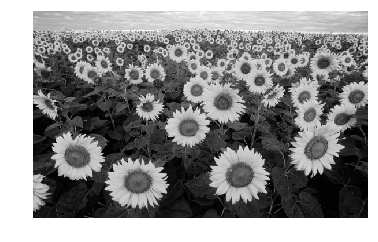

In [3]:
im = cv2.imread("Sunflowers.jpg",0)
plt.imshow(im,cmap="gray")
plt.axis("off")
plt.show()

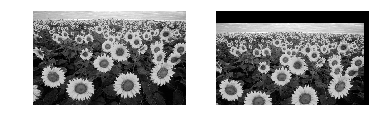

In [4]:
H = np.array([[1,0,-20],[0,1,50],[0,0,1]],dtype = "float32")
#im_t = np.zeros(im.shape)
im2 = cv2.warpPerspective(im, H, (im.shape[1],im.shape[0]))

plt.subplot(121)
plt.imshow(im,cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()

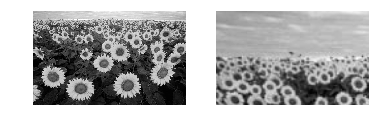

In [5]:
s = 5
H = np.array([[s,0,0],[0,s,0],[0,0,1]],dtype = "float32")
#im_t = np.zeros(im.shape)
im2 = cv2.warpPerspective(im, H, (im.shape[1],im.shape[0]))

plt.subplot(121)
plt.imshow(im,cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()

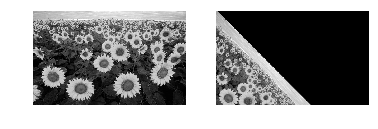

In [6]:
th = 45*np.pi/180.0

H = np.array([[np.cos(th),-np.sin(th),0],[np.sin(th),np.cos(th),0],[0,0,1]],dtype = "float32")

im2 = cv2.warpPerspective(im, H, (im.shape[1],im.shape[0]))

plt.subplot(121)
plt.imshow(im,cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()

# Alineamiento de imágenes

Supón que tenemos dos imágenes de la misma escena pero tomadas en diferentes instantes de tiempo y, posiblemente, mediante instrumentos diferentes. Por ejemplo:

* Imágenes médicas obtenidas de la misma sección anatómica de un mismo paciente en diferentes momentos.
* Imágenes satelitales de [aproximadamente] una misma región.
* Imágenes consecutivas de una cámara montada sobre un robot móvil.

Suponemos que las imágenes son tales que **existe una homografía** que, aplicada a una de las imágenes puede transformarla para alinear los puntos correspondientes en ambas imágenes.  

Toma como ejemplo a las siguientes imágenes:

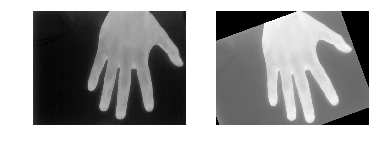

In [7]:
im1 = cv2.imread("1_0.png",0)
im2 = cv2.imread("I_2.png",0)

plt.subplot(121)
plt.imshow(im1,cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()

En las siguientes celdas describiremos dos estrategias para recuperar la matriz de homografía.

Obtenemos las envolventes convexas de ambas imágenes.

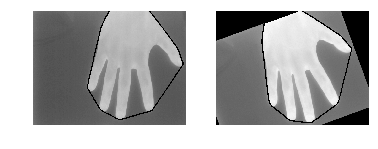

In [8]:
ret, im_th1 = cv2.threshold(im1, 135, 255, 0)
ret, im_th2 = cv2.threshold(im2, 135, 255, 0)

cont1, jerarq = cv2.findContours(im_th1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cont2, jerarq = cv2.findContours(im_th2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

hull1 = cv2.convexHull(cont1[0])
hull2 = cv2.convexHull(cont2[0])

im_h1 = im1.copy()
im_h2 = im2.copy()

cv2.drawContours(im_h1, [hull1], -1, (0, 0, 255), 3)
cv2.drawContours(im_h2, [hull2], -1, (0, 0, 255), 3)

plt.subplot(121)
plt.imshow(im_h1,cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(im_h2,cmap="gray")
plt.axis("off")
plt.show()

## Búsqueda de puntos correspondientes

* Buscamos correspondencias **a mano**

In [9]:
len(hull2)

40

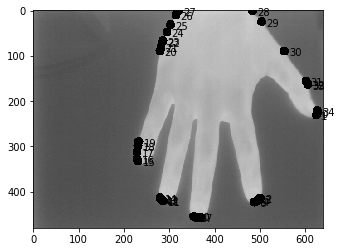

In [10]:
imc1 = im1.copy()

fig = plt.figure()
ax = fig.add_subplot(111)
for i,p in enumerate(hull1):
    cv2.circle(imc1,(p[0][0],p[0][1]),10,3,-1)
    if i%1==0:
        ax.annotate(str(i),xy=((p[0][0]+10,p[0][1]+10)))
plt.imshow(imc1,cmap="gray")
plt.show()

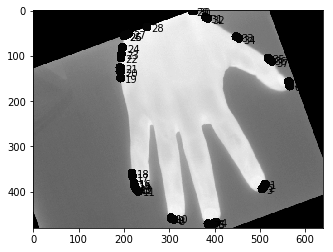

In [13]:
imc2 = im2.copy()

fig = plt.figure()
ax = fig.add_subplot(111)

for i,p in enumerate(hull2):
    cv2.circle(imc2,(p[0][0],p[0][1]),10,3,-1)
    if i%1==0:
        ax.annotate(str(i),xy=((p[0][0]+10,p[0][1]+10)))
    
plt.imshow(imc2,cmap="gray")
plt.show()

Comparamos las intensidades de parejas de puntos

In [57]:
pts = []
w = 10
r2 = w**2
for i1, hu1 in enumerate(hull1):
    val = []
    for i2, hu2 in enumerate(hull2):
        (x1,y1) = (hu1[0][0], hu1[0][1])
        (x2,y2) = (hu2[0][0], hu2[0][1])

        ints1 = []
        ints2 = []
        for i in range(-w,w+1):
            for j in range(-w,w+1):
                d2 = i**2+j**2
                if d2 <= r2:
                    x1p = x1+i
                    y1p = y1+j
                    x2p = x2+i
                    y2p = y2+j
                    flag = [False, False]
                    f = np.logical_and([x1p > 0, y1p > 0], [x1p < im1.shape[1], y1p < im1.shape[0]])
                    flag[0] = np.logical_and(f[0], f[1])
                    f = np.logical_and([x2p > 0, y2p > 0], [x2p < im2.shape[1], y2p < im2.shape[0]])
                    flag[1] = np.logical_and(f[0], f[1])
                    if np.logical_and(flag[0], flag[1]): 
                        if im2[y2p, x2p] != 0:
                            ints1.append(float(im1[y1p,x1p]))
                            ints2.append(float(im2[y2p,x2p]))
        ints1.sort() 
        ints2.sort() 
        m = np.column_stack((ints1,ints2))
        #Diferencia de cuadrados
        n = np.column_stack((np.subtract(m[:,0],m[:,1]))**2)
        #Promedio
        nprom = np.mean(n)
        #Guardamos valores
        val.append((nprom, i2))
    #Acomodamos
    val.sort()
    #Guardar indice
    pts.append(val[0][1])

pts1 = []; pts2 = []
pts1 = [[h[0][0], h[0][1]] for h in hull1 ]
pts2 = [[hull2[i][0][0], hull2[i][0][1] ] for i in pts ]
pts1 = np.array(pts1, dtype=float)
pts2 = np.array(pts2, dtype=float)

Homografía:
[[   1.55    0.24 -188.72]
 [  -0.21    1.1   140.25]
 [   0.     -0.      1.  ]]


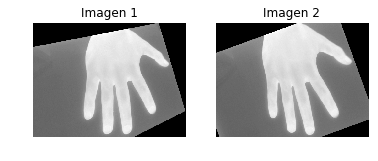

In [58]:
homo, c = cv2.findHomography(pts1, pts2)
print "Homografía:\n" + str(np.around(homo, decimals=2))
imt = cv2.warpPerspective(im1,homo,(im1.shape[1],im1.shape[0]))
plt.subplot(1,2,1)
plt.title("Imagen 1")
plt.imshow(imt,cmap="gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Imagen 2")
plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()

In [54]:
np.mean(np.column_stack((np.subtract(m[:,0],m[:,1]))**2))

13.31230283911672

In [16]:
v1 = np.array(ints1)
v2 = np.array(ints2)
np.linalg.norm(v1-v2)/float(len(v1))

0.3300414296441783

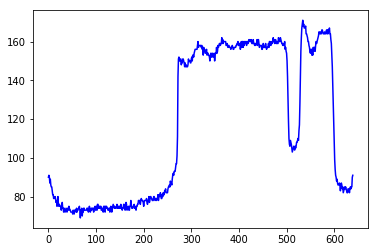

In [17]:
plt.plot(im1[150,:],"b")
plt.show()

# Tarea xDD

In [18]:
pi1 = [ 1,5,8,11,15,20,26,28,30 ] 
pi2 = [ 0,3,5,8,11,19,25,30,34 ]

pts1 = []; pts2 = []
# Filtramos puntos correspondientes a los encontrados mediante el aspecto visual
pts1 = [[h[0][0], h[0][1]] for i,h in enumerate(hull1) if i in pi1 ]
pts2 = [[h[0][0], h[0][1]] for i,h in enumerate(hull2) if i in pi2 ]
# Convertimos la lista de puntos a un arreglo de tipo float
pts1 = np.array(pts1, dtype=float)
pts2 = np.array(pts2, dtype=float)

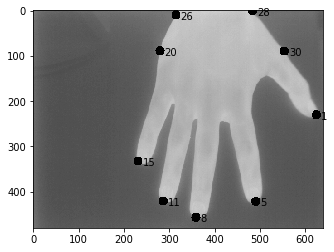

In [19]:
imc1 = im1.copy()
fig = plt.figure()
ax = fig.add_subplot(111)
# [ 1,5,8,11,15,20,26,28,30 ] len = 9
for i,p in enumerate(hull1):
    if i in pi1:
        cv2.circle(imc1,(p[0][0],p[0][1]),10,3,-1)
        if i%1==0:
            ax.annotate(str(i),xy=((p[0][0]+10,p[0][1]+10)))
plt.imshow(imc1,cmap="gray")
plt.show()

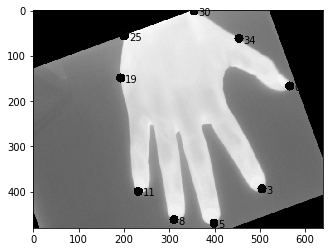

In [20]:
imc2 = im2.copy()
fig = plt.figure()
ax = fig.add_subplot(111)
# [ 0,3,5,8,11,19,25,30,34 ] len = 9
for i,p in enumerate(hull2):
    if i in pi2:
        cv2.circle(imc2,(p[0][0],p[0][1]),10,3,-1)
        if i%1==0:
            ax.annotate(str(i),xy=((p[0][0]+10,p[0][1]+10)))
plt.imshow(imc2,cmap="gray")
plt.show()

Homografía:
[[   1.02    0.36 -118.95]
 [  -0.32    0.99  153.34]
 [   0.      0.      1.  ]]


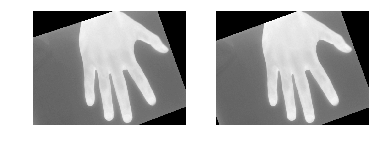

In [21]:
# Encontramos la homografía que alinea la primera imagen con la segunda
homo, c = cv2.findHomography(pts1, pts2)
print "Homografía:\n" + str(np.around(homo, decimals=2))
imt = cv2.warpPerspective(im1,homo,(im1.shape[1],im1.shape[0]))
plt.subplot(1,2,1)
plt.imshow(imt,cmap="gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()


Homografía:
[[   0.88   -0.32  153.76]
 [   0.3     0.92 -105.08]
 [  -0.      0.      1.  ]]


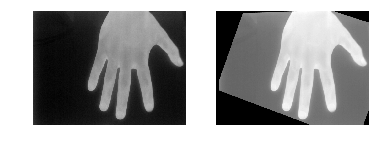

In [22]:
# Encontramos la homografía que alinea la segunda imagen con la primera
homo, c = cv2.findHomography(pts2, pts1)
print ""
print "Homografía:\n" + str(np.around(homo, decimals=2))
imt = cv2.warpPerspective(im2,homo,(im2.shape[1],im2.shape[0]))
plt.subplot(1,2,1)
plt.imshow(im1,cmap="gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(imt,cmap="gray")
plt.axis("off")
plt.show()

### Conclusión

Identificando puntos criticos sobre la envolvente convexa de ambas imagenes de la mano derecha que coinciden respectivamente con los dedos de cada imagen podemos aplicar las funciones de <i>OpenCV</i> para recuperar y aplicar la rhomografía obtenida en ambos casos para poder alinear las imagenes, por lo que podemos visualizar la alineación a primera vista se bien pero no es precisa ya que se puede notar que totalmente ambas manos no coinciden con total precisión, lo puntos malos de realizar este método es que necesitamos conocer los puntos que se asemejan a la ubicación de la envolvente convexa sobre ambas imagenes.